In [1]:
from desc_dc2_dm_data import REPOS
from lsst.daf.persistence import Butler
import lsst.geom as geom
from lsst.skymap import makeSkyPolygonFromBBox
from tqdm import tqdm
import galsim
import numpy as np

In [2]:
butler = Butler(REPOS['2.2i_dr6_wfd'])

/tmp/ipykernel_62281/1714644865.py:1: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = Butler(REPOS['2.2i_dr6_wfd'])
/tmp/ipykernel_62281/1714644865.py:1: FutureWarning: Gen2 Butler has been deprecated (ImsimMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = Butler(REPOS['2.2i_dr6_wfd'])


CameraMapper INFO: Loading exposure registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/registry.sqlite3
CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/CALIB/calibRegistry.sqlite3
CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/CALIB/calibRegistry.sqlite3
CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/CALIB/calibRegistry.sqlite3
LsstCamMapper WARN: Unable to find valid calib root directory
CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/CALIB/calibRegistry.sqlite3
CameraMapper INFO: Loading exposure registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/registry.sqlite3
CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_

In [21]:
geom.Extent2I()

lsst.geom.Extent2I

In [22]:
skymap = butler.get("deepCoadd_skyMap")

# Near the center of DC2
ra = 64.0  # degrees
dec = -36.0 # degrees
point = geom.SpherePoint(ra, dec, geom.degrees)
cutoutSize = geom.ExtentI(2001, 2001)

tractInfo = skymap.findTract(point)
patchInfo = tractInfo.findPatch(point)
xy = geom.PointI(tractInfo.getWcs().skyToPixel(point))
bbox = geom.BoxI(xy - cutoutSize//2, cutoutSize)
coaddId = {
    'tract':tractInfo.getId(), 
    'patch':f"%d,%d"%patchInfo.getIndex(),
    'filter':'r'
}
coadd = butler.get("deepCoadd_sub", bbox=bbox, immediate=True, dataId=coaddId)

In [23]:


# Get visits contributing to this cutout
visitIds = []
for ccd in tqdm(coadd.getInfo().getCoaddInputs().ccds):
    dataId = {
        'visit':ccd['visit'], 
        'detector':ccd['ccd'], 
        'filter':ccd['filter'],
        'tract':tractInfo.getId()
    }
    wcs = butler.get('calexp_wcs', dataId=dataId)   # Note 99% of cell execution time is this line and the next
    bbox = butler.get('calexp_bbox', dataId=dataId)
    poly = makeSkyPolygonFromBBox(bbox, wcs)
    if poly.contains(point.getVector()):
        visitIds.append(dataId)



100%|██████████| 517/517 [01:32<00:00,  5.58it/s]


In [24]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from mpl_toolkits.axisartist.grid_finder import DictFormatter, MaxNLocator

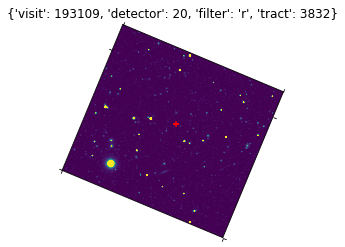

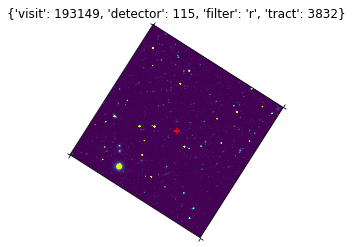

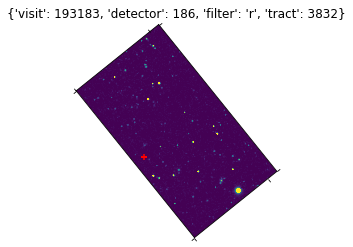

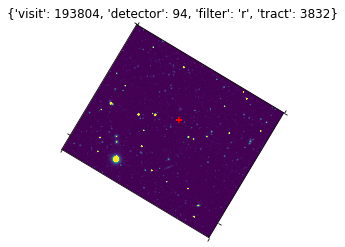

In [25]:
plt.close('all')

# Get image cutouts
n_max_cutout = 4

for dataId in visitIds[:n_max_cutout]:
    wcs = butler.get('calexp_wcs', dataId=dataId)
    bbox = butler.get('calexp_bbox', dataId=dataId)
    xy = geom.PointI(wcs.skyToPixel(point))
    cutout = geom.BoxI(xy - cutoutSize//2, cutoutSize)
    bbox.clip(cutout)
    image = butler.get("calexp_sub", bbox=bbox, immediate=True, dataId=dataId)

    mat = np.eye(3)
    mat[:2,:2] = wcs.getCdMatrix()
    transform = Affine2D(mat)
    
    fig = plt.figure()
    arr = image.maskedImage.image.array
    plot_extents = 0, bbox.width, 0, bbox.height
    helper = floating_axes.GridHelperCurveLinear(
        transform, plot_extents, 
        tick_formatter1=DictFormatter({}),
        tick_formatter2=DictFormatter({}),
        grid_locator1=MaxNLocator(nbins=1),
        grid_locator2=MaxNLocator(nbins=1),
    )
    ax = floating_axes.FloatingSubplot(fig, 111, grid_helper=helper)
    ax.imshow(arr, vmin=0, vmax=300, transform=transform+ax.transData)
    ax.set_title(repr(dataId))
    ax.scatter(
        xy.x - bbox.minX, 
        xy.y - bbox.minY, 
        c='r', marker='+', transform=transform+ax.transData
    )
    fig.add_subplot(ax)
    fig.show()

In [11]:
50 / 3600

0.013888888888888888

In [26]:


from astropy.table import Table
import astropy.io.fits as fits
import numpy as np

# Not sure if all of these are needed.
table = Table()
table['raJ2000'] = np.array([np.deg2rad(64.0),])
table['decJ2000'] = np.array([np.deg2rad(-36.0),])
table['sourceType'] = np.array(["galaxy", "galaxy"])
table['DiskHalfLightRadius'] = np.array([2.0,])
table['BulgeHalfLightRadius'] = np.array([2.0,])
table['umagVar'] = np.array([19.0,])
table['gmagVar'] = np.array([19.0,])
table['rmagVar'] = np.array([19.0,])
table['imagVar'] = np.array([19.0,])
table['zmagVar'] = np.array([19.0,])
table['ymagVar'] = np.array([19.0,])
table['disk_n'] = np.array([1.0,])
table['bulge_n'] = np.array([3.0,])
table['a_d'] = np.array([4.0,])
table['a_b'] = np.array([4.0,])
table['b_d'] = np.array([1.0,])
table['b_b'] = np.array([1.0,])
table['pa_disk'] = np.array([35.0,])
table['pa_bulge'] = np.array([55.0,])

table.write("fsi.fits", overwrite=True)



In [27]:


n_max_cutout = 4
for dataId in visitIds[:n_max_cutout]:
    visit = dataId['visit']    
    detector = dataId['detector']
    !processCcdWithFakes.py /global/cfs/cdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-calexp-v1 \
      --output test \
      --id visit=$visit detector=$detector \
      -c insertFakes.fakeType=fsi.fits \
      --clobber-config --no-versions



/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.6.0/Linux64/pipe_base/21.0.0-29-gf27b79e+8c09b75fa7/python/lsst/pipe/base/argumentParser.py:686: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(inputs=inputs, outputs=outputs)
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.6.0/Linux64/pipe_base/21.0.0-29-gf27b79e+8c09b75fa7/python/lsst/pipe/base/argumentParser.py:686: FutureWarning: Gen2 Butler has been deprecated (ImsimMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(inputs=inputs, outputs=outputs)
CameraMapper INFO: Loading exposure registry from /global/cscratch1/sd/desc/DC2/data/Run2.1i_globus_20200715/w_2019_19-v1/registry.sqlite3
CameraMapper INFO: Loading calib registry from /global/cscratch1/sd/desc/DC2/data/Run2.1i_globus_20200715/w_2019_19-v1/CALIB/calibRegistry.sql

In [28]:
fakes_butler = Butler("test/")

CameraMapper INFO: Loading exposure registry from /global/cscratch1/sd/desc/DC2/data/Run2.1i_globus_20200715/w_2019_19-v1/registry.sqlite3
CameraMapper INFO: Loading calib registry from /global/cscratch1/sd/desc/DC2/data/Run2.1i_globus_20200715/w_2019_19-v1/CALIB/calibRegistry.sqlite3
CameraMapper INFO: Loading calib registry from /global/cscratch1/sd/desc/DC2/data/Run2.1i_globus_20200715/w_2019_19-v1/CALIB/calibRegistry.sqlite3
CameraMapper INFO: Loading calib registry from /global/cscratch1/sd/desc/DC2/data/Run2.1i_globus_20200715/w_2019_19-v1/CALIB/calibRegistry.sqlite3
LsstCamMapper WARN: Unable to find valid calib root directory
LsstCamMapper WARN: Unable to find valid calib root directory
CameraMapper INFO: Loading calib registry from /global/cscratch1/sd/desc/DC2/data/Run2.1i_globus_20200715/w_2019_19-v1/CALIB/calibRegistry.sqlite3
CameraMapper INFO: Loading exposure registry from /global/cscratch1/sd/desc/DC2/data/Run2.1i_globus_20200715/w_2019_19-v1/registry.sqlite3
CameraMapp

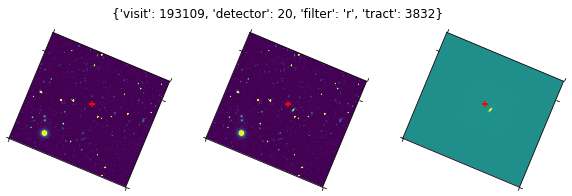

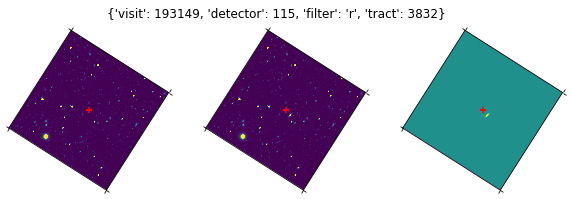

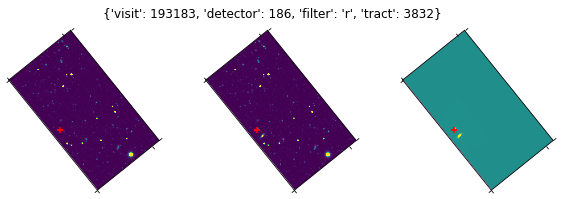

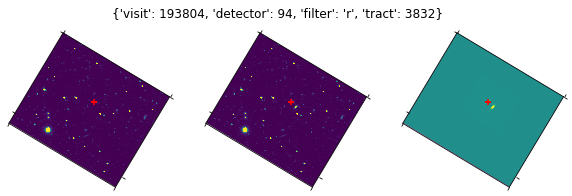

In [29]:
plt.close('all')
# Get image cutouts
n_max_cutout = 4
for dataId in visitIds[:n_max_cutout]:
    wcs = butler.get('calexp_wcs', dataId=dataId)
    bbox = butler.get('calexp_bbox', dataId=dataId)
    xy = geom.PointI(wcs.skyToPixel(point))
    cutout = geom.BoxI(xy - cutoutSize//2, cutoutSize)
    bbox.clip(cutout)
    image = butler.get("calexp_sub", bbox=bbox, immediate=True, dataId=dataId)
    fake_image = fakes_butler.get("fakes_calexp_sub", bbox=bbox, immediate=True, dataId=dataId)

    mat = np.eye(3)
    mat[:2,:2] = wcs.getCdMatrix()
    transform = Affine2D(mat)
    
    fig = plt.figure(figsize=(10, 3))
    arr = image.maskedImage.image.array
    plot_extents = 0, bbox.width, 0, bbox.height
    helper = floating_axes.GridHelperCurveLinear(
        transform, plot_extents, 
        tick_formatter1=DictFormatter({}),
        tick_formatter2=DictFormatter({}),
        grid_locator1=MaxNLocator(nbins=1),
        grid_locator2=MaxNLocator(nbins=1),
    )
    ax = floating_axes.FloatingSubplot(fig, 131, grid_helper=helper)
    ax.imshow(arr, vmin=0, vmax=300, transform=transform+ax.transData)
    ax.scatter(
        xy.x - bbox.minX, 
        xy.y - bbox.minY, 
        c='r', marker='+', transform=transform+ax.transData
    )
    fig.add_subplot(ax)

    ax = floating_axes.FloatingSubplot(fig, 132, grid_helper=helper)
    fake_arr = fake_image.maskedImage.image.array
    ax.imshow(fake_arr, vmin=0, vmax=300, transform=transform+ax.transData)
    ax.scatter(
        xy.x - bbox.minX, 
        xy.y - bbox.minY, 
        c='r', marker='+', transform=transform+ax.transData
    )
    fig.add_subplot(ax)

    ax = floating_axes.FloatingSubplot(fig, 133, grid_helper=helper)
    diff_arr = fake_arr - arr
    ax.imshow(diff_arr, vmin=-100, vmax=100, transform=transform+ax.transData)
    ax.scatter(
        xy.x - bbox.minX, 
        xy.y - bbox.minY, 
        c='r', marker='+', transform=transform+ax.transData
    )
    fig.add_subplot(ax)
    
    fig.suptitle(repr(dataId))
    fig.show()


In [43]:
np.array(diff_arr.shape) * 0.2 / 60

array([6.67      , 5.66333333])

In [38]:
np.array(diff_arr.shape) * 0.2 / 60

array([6.67      , 5.66333333])